In [36]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import math
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [37]:
#drops rows with missing or N/A

import pandas as pd


input_file_path = 'data.csv'
output_file_path = 'cleaned_ML_data.csv'

df = pd.read_csv(input_file_path)

df_cleaned = df.dropna()


df_cleaned.to_csv(output_file_path, index=False)

print("Cleaning complete. Cleaned data saved to", output_file_path)


Cleaning complete. Cleaned data saved to cleaned_ML_data.csv


In [38]:
#drops cars that arent in years 2014-2015

import pandas as pd

input_file_path = 'cleaned_ML_data.csv'
output_file_path = 'cleaned_ML_data1.csv'

df = pd.read_csv(input_file_path)

valid_years = [2014, 2015, 2016, 2017]
df_filtered = df[df['Year'].isin(valid_years)]

df_cleaned = df_filtered.dropna()

df_cleaned.to_csv(output_file_path, index=False)

print("Cleaning complete. Cleaned data saved to", output_file_path)


Cleaning complete. Cleaned data saved to cleaned_ML_data1.csv


In [39]:
#dropped the cars that dont have 2 or 4 doors

import pandas as pd

csv_path = 'cleaned_ML_data1.csv'
df = pd.read_csv(csv_path)

filtered_df = df[df['Number of Doors'].isin([2, 4])]

filtered_df.to_csv('cleaned_ML_data2.csv', index=False)


In [40]:
#diagnostics of the dataset

import pandas as pd

csv_path = 'cleaned_ML_data8.csv'
df = pd.read_csv(csv_path)

def frequency_percentage(df):
    frequency_dict = {}
    for column in df.columns:
        frequency = df[column].value_counts()
        percentage = df[column].value_counts(normalize=True) * 100
        frequency_df = pd.DataFrame({f'{column} Frequency': frequency, f'{column} Percentage': percentage})
        frequency_dict[column] = frequency_df.sort_values(by=f'{column} Frequency', ascending=False)
    return frequency_dict

frequency_dict = frequency_percentage(df)

for column, freq_df in frequency_dict.items():
    print(f'--- {column} ---')
    print(freq_df)
    print('\n')


--- Engine Fuel Type ---
                  Engine Fuel Type Frequency  Engine Fuel Type Percentage
premium_unleaded                        2237                    46.838358
regular unleaded                        1823                    38.170017
flex_fuel                                591                    12.374372
diesel                                   125                     2.617253


--- Engine Cylinders ---
     Engine Cylinders Frequency  Engine Cylinders Percentage
4.0                        2158                    45.184255
6.0                        1789                    37.458124
8.0                         829                    17.357621


--- Transmission Type ---
           Transmission Type Frequency  Transmission Type Percentage
AUTOMATIC                         3649                     76.402848
MANUAL                            1127                     23.597152


--- Driven_Wheels ---
                   Driven_Wheels Frequency  Driven_Wheels Percentage
all wh

In [41]:
#remove direct drive cars and combine automated manual with manual

import pandas as pd

df = pd.read_csv('cleaned_ML_data2.csv')

df = df[df['Transmission Type'] != 'DIRECT_DRIVE']

df['Transmission Type'] = df['Transmission Type'].replace('AUTOMATED_MANUAL', 'MANUAL')

df.to_csv('cleaned_ML_data3.csv', index=False)


In [42]:
#Combine four wheel drive with all wheel drive

import pandas as pd

df = pd.read_csv('cleaned_ML_data3.csv')

df['Driven_Wheels'] = df['Driven_Wheels'].replace('four wheel drive', 'all wheel drive')

df.to_csv('cleaned_ML_data4.csv', index=False)


In [43]:
#combine the fuel types and drop make model and year

import pandas as pd

df = pd.read_csv('cleaned_ML_data4.csv')

df['Engine Fuel Type'] = df['Engine Fuel Type'].replace('premium unleaded (required)', 'premium_unleaded')
df['Engine Fuel Type'] = df['Engine Fuel Type'].replace('premium unleaded (recommended)', 'premium_unleaded')
df['Engine Fuel Type'] = df['Engine Fuel Type'].replace('flex-fuel (unleaded/E85)', 'flex_fuel')
df['Engine Fuel Type'] = df['Engine Fuel Type'].replace('flex-fuel (premium unleaded required/E85)', 'flex_fuel')
df['Engine Fuel Type'] = df['Engine Fuel Type'].replace('flex-fuel (premium unleaded recommended/E85)', 'flex_fuel')

df = df.drop(['Make', 'Model', 'Year'], axis=1, errors='ignore')

df.to_csv('cleaned_ML_data5.csv', index=False)


In [44]:
#Simplified the market categories and vehicle styles

import pandas as pd

df = pd.read_csv('cleaned_ML_data5.csv')

def simplify_market_category(category):
    if pd.isna(category):
        return 'Other'  # for handling NaN values
    primary_categories = ['Luxury', 'Performance', 'Flex Fuel', 'Crossover', 'Exotic', 'Hybrid']
    for primary in primary_categories:
        if primary in category:
            return primary
    return 'Other'

df['Market Category'] = df['Market Category'].apply(simplify_market_category)

def simplify_vehicle_style(style):
    if 'SUV' in style:
        return 'SUV'
    elif 'Hatchback' in style:
        return 'Hatchback'
    elif 'Pickup' in style:
        return 'Pickup'
    elif 'Minivan' in style:
        return 'Minivan'
    else:
        return style

df['Vehicle Style'] = df['Vehicle Style'].apply(simplify_vehicle_style)

df.to_csv('cleaned_ML_data6.csv', index=False)


In [45]:
#dropped all cars that werent 4 6 or 8 cylinders

import pandas as pd

df = pd.read_csv('cleaned_ML_data6.csv')

df = df[df['Engine Cylinders'].isin([4.0, 6.0, 8.0])]

df.to_csv('cleaned_ML_data7.csv', index=False)


In [46]:
#binned the continous variables

import pandas as pd

input_file_path = 'cleaned_ML_data7.csv'
output_file_path = 'cleaned_ML_data8.csv'

df = pd.read_csv(input_file_path)

columns_to_binned = ['highway MPG', 'city mpg', 'Popularity', 'MSRP', 'Engine HP']

for column in columns_to_binned:
    # Use qcut to create 10 buckets based on percentiles
    df[column+'_Binned'] = pd.qcut(df[column], q=10, labels=False, duplicates='drop')

df = df.drop(columns=columns_to_binned)

df.to_csv(output_file_path, index=False)

print("Binning complete. Binned data saved to", output_file_path)


Binning complete. Binned data saved to cleaned_ML_data8.csv


In [47]:
#removed all categorical variables for the regression analysis

import pandas as pd

def modify_csv(file_path):
    columns_to_remove = [
        'Engine Fuel Type', 'Engine Cylinders', 'Transmission Type', 
        'Driven_Wheels', 'Market Category', 
        'Vehicle Size', 'Vehicle Style'
    ]

    df = pd.read_csv('cleaned_ML_data7.csv')
    
    df.drop(columns=columns_to_remove, inplace=True, errors='ignore')
    
    df.to_csv('cleaned_ML_data9.csv', index=False)
    print("Modified data saved to 'cleaned_ML_data9.csv'.")

file_path = 'your_file.csv'
modify_csv(file_path)


Modified data saved to 'cleaned_ML_data9.csv'.


In [48]:
#dropped all the cars that cost over $100k

import pandas as pd

def filter_csv(file_path, output_file_path):
    df = pd.read_csv(file_path)

    df_filtered = df[df['MSRP'] <= 100000]
    
    df_filtered.to_csv(output_file_path, index=False)
    print(f"Filtered data saved to '{output_file_path}'.")

file_path = 'cleaned_ML_data9.csv'
output_file_path = 'cleaned_ML_data10.csv'
filter_csv(file_path, output_file_path)


Filtered data saved to 'cleaned_ML_data10.csv'.


In [49]:
import pandas as pd

data = pd.read_csv('cleaned_ML_data7.csv')

def categorize_msrp(msrp):
    if msrp <= 30000:
        return 'budget'
    elif msrp <= 50000:
        return 'economy'
    elif msrp <= 80000:
        return 'performance'
    elif msrp <= 150000:
        return 'luxury'
    else:
        return 'supercar'

data['Category'] = data['MSRP'].apply(categorize_msrp)

output_file_path = 'cleaned_ML_data11.csv'
data.to_csv(output_file_path, index=False)




In [50]:
#Manually drops cars into 5 buckets based on discretion

import pandas as pd

input_file_path = 'cleaned_ML_data11.csv'
output_file_path = 'cleaned_ML_data12.csv'

df = pd.read_csv(input_file_path)

columns_to_binned = ['highway MPG', 'city mpg', 'Popularity', 'Engine HP']

for column in columns_to_binned:
    df[column+'_Binned'] = pd.qcut(df[column], q=10, labels=False, duplicates='drop')

df = df.drop(columns=columns_to_binned)

df.to_csv(output_file_path, index=False)

print("Binning complete. Binned data saved to", output_file_path)


Binning complete. Binned data saved to cleaned_ML_data12.csv


In [51]:
df = pd.read_csv(r'cleaned_ML_data8.csv')
df

,Engine Fuel Type,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG_Binned,city mpg_Binned,Popularity_Binned,MSRP_Binned,Engine HP_Binned
0,premium_unleaded,4.0,MANUAL,rear wheel drive,2.0,Performance,Compact,Convertible,8,8,3,1,0
1,premium_unleaded,4.0,MANUAL,rear wheel drive,2.0,Performance,Compact,Convertible,8,8,3,1,0
2,premium_unleaded,4.0,MANUAL,rear wheel drive,2.0,Performance,Compact,Convertible,8,8,3,2,0
3,premium_unleaded,4.0,AUTOMATIC,rear wheel drive,2.0,Luxury,Compact,Coupe,8,7,8,3,3
4,premium_unleaded,4.0,AUTOMATIC,rear wheel drive,2.0,Luxury,Compact,Convertible,8,7,8,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4771,premium_unleaded,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,2,2,8,7,6
4772,premium_unleaded,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,2,2,8,8,7
4773,premium_unleaded,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,2,2,8,8,6
4774,premium_unleaded,4.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,8,6,8,7,3


/var/folders/cn/kklpt8s55zx1q68hpknb0khm0000gn/T/ipykernel_21384/1819509472.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


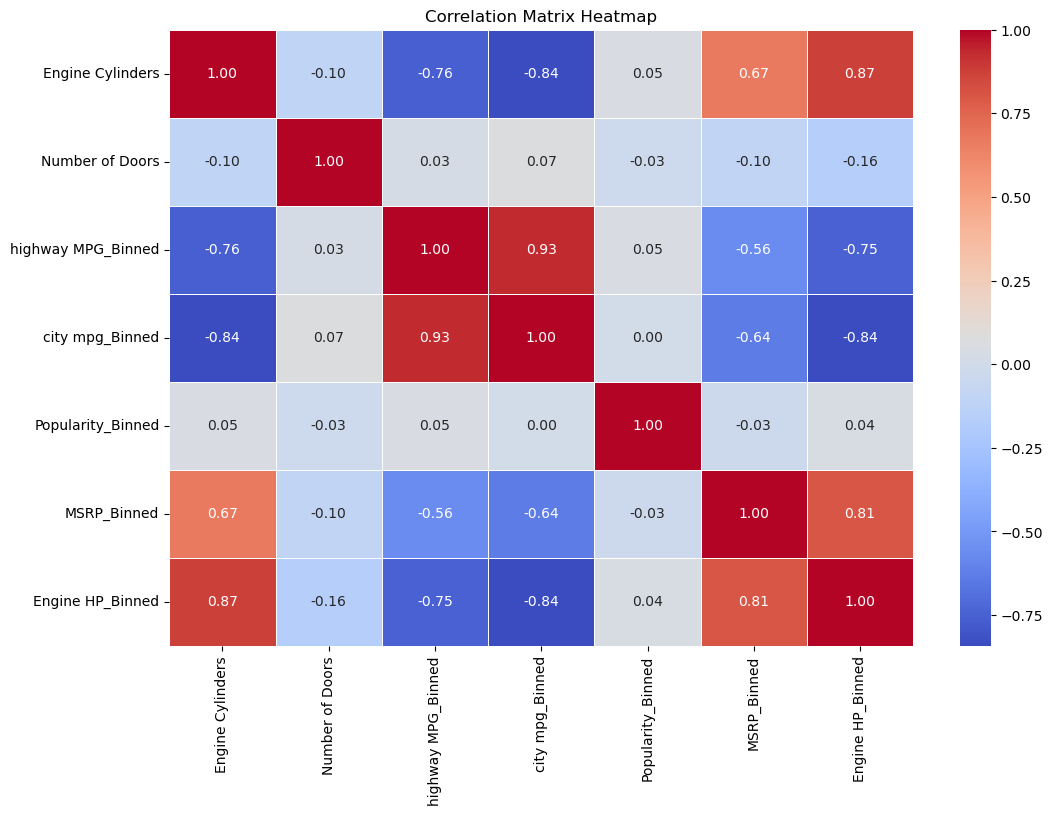

In [52]:
#Confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


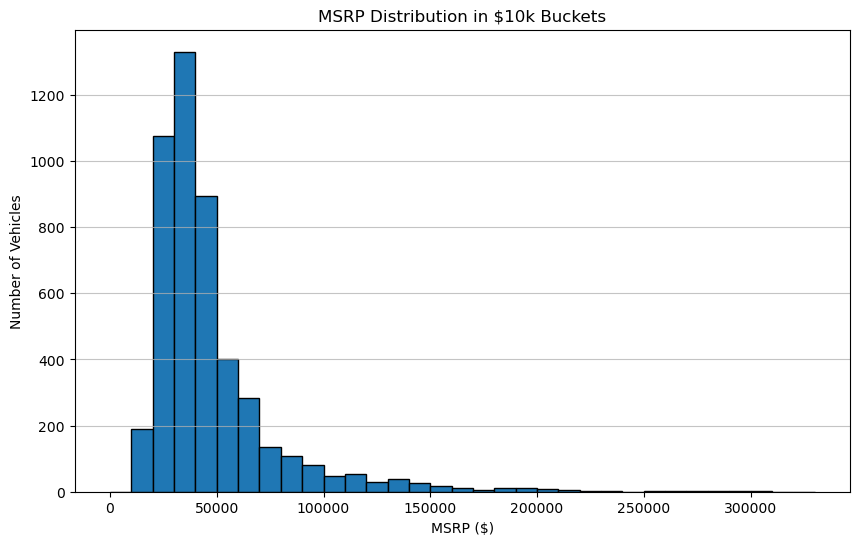

In [53]:
#Distribution for whole dataset

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ML_data9.csv')

bins = [i for i in range(0, 340000, 10000)]

plt.figure(figsize=(10, 6))
plt.hist(df['MSRP'], bins=bins, edgecolor='black')

plt.title('MSRP Distribution in $10k Buckets')
plt.xlabel('MSRP ($)')
plt.ylabel('Number of Vehicles')

plt.grid(axis='y', alpha=0.75)
plt.show()


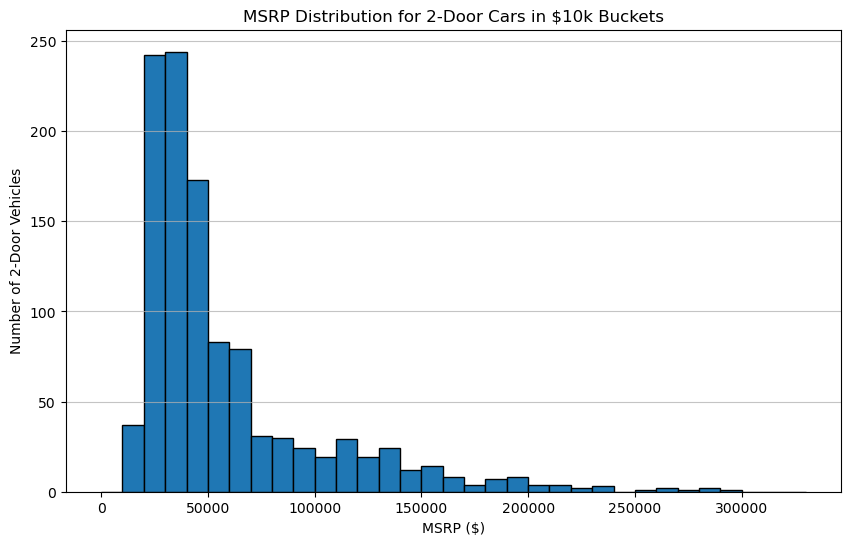

In [54]:
#Distribution for 2 door cars

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ML_data9.csv')

df_2_doors = df[df['Number of Doors'] == 2]

bins = [i for i in range(0, 340000, 10000)]

plt.figure(figsize=(10, 6))
plt.hist(df_2_doors['MSRP'], bins=bins, edgecolor='black')

plt.title('MSRP Distribution for 2-Door Cars in $10k Buckets')
plt.xlabel('MSRP ($)')
plt.ylabel('Number of 2-Door Vehicles')

plt.grid(axis='y', alpha=0.75)
plt.show()


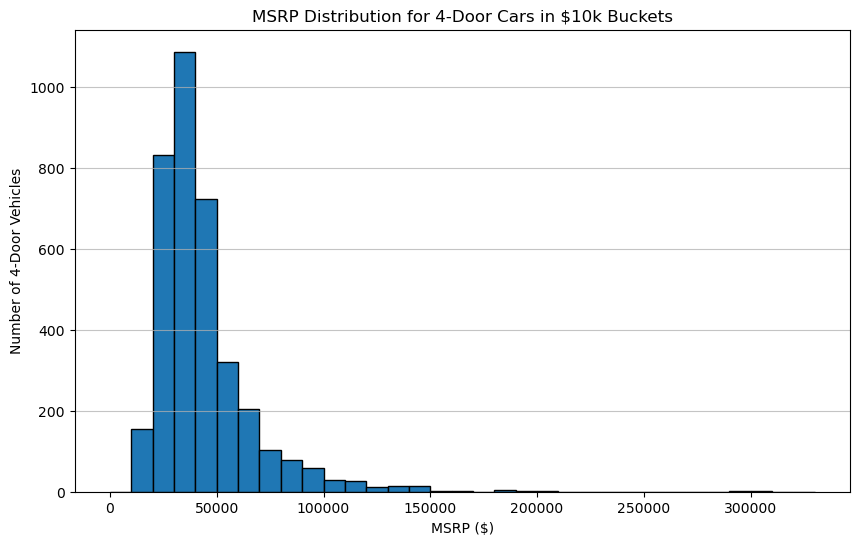

In [55]:
#Distribution for 4 door cars

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ML_data9.csv')

df_2_doors = df[df['Number of Doors'] == 4]

bins = [i for i in range(0, 340000, 10000)]

plt.figure(figsize=(10, 6))
plt.hist(df_2_doors['MSRP'], bins=bins, edgecolor='black')

plt.title('MSRP Distribution for 4-Door Cars in $10k Buckets')
plt.xlabel('MSRP ($)')
plt.ylabel('Number of 4-Door Vehicles')

plt.grid(axis='y', alpha=0.75)
plt.show()


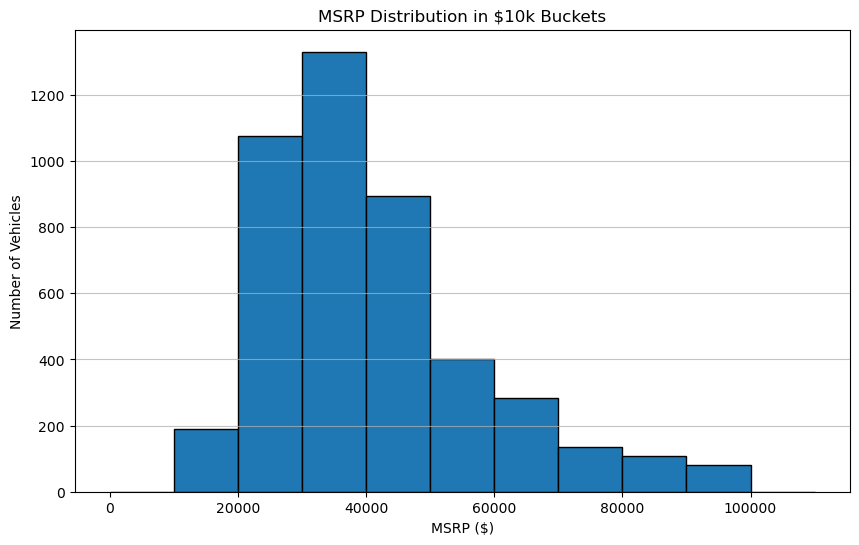

In [56]:
#Distribution removing cars over $100k

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ML_data10.csv')

bins = [i for i in range(0, 120000, 10000)]

plt.figure(figsize=(10, 6))
plt.hist(df['MSRP'], bins=bins, edgecolor='black')

plt.title('MSRP Distribution in $10k Buckets')
plt.xlabel('MSRP ($)')
plt.ylabel('Number of Vehicles')

plt.grid(axis='y', alpha=0.75)
plt.show()


In [57]:
rows_with_nan = df[df.isna().any(axis=1)]

print(rows_with_nan)

Empty DataFrame
Columns: [Engine HP, Number of Doors, highway MPG, city mpg, Popularity, MSRP]
Index: []


In [58]:
columns_with_nan = df.columns[df.isna().any()].tolist()
print(columns_with_nan)

[]


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


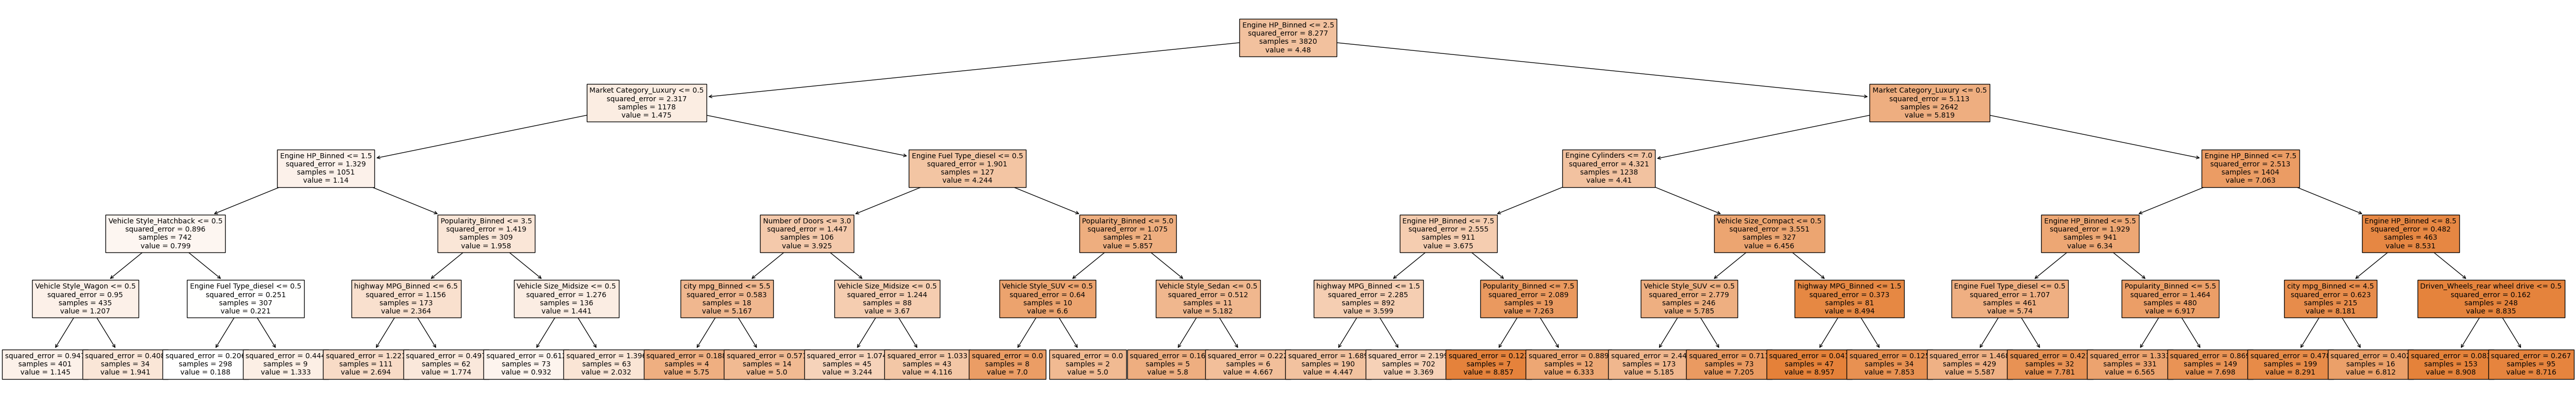

In [67]:
#decision tree depth 5

import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ML_data8.csv')
X = df.drop('MSRP_Binned', axis=1)  # Assuming 'MSRP_Binned' is the target
y = df['MSRP_Binned']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object']))
encoded_columns = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns, index=X.index)

X_combined = pd.concat([X_encoded_df, X.select_dtypes(exclude=['object'])], axis=1)

X_combined.columns = X_combined.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(65,10))
plot_tree(tree_model, filled=True, feature_names=X_combined.columns.tolist(), max_depth=5, fontsize=10)
plt.show()


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


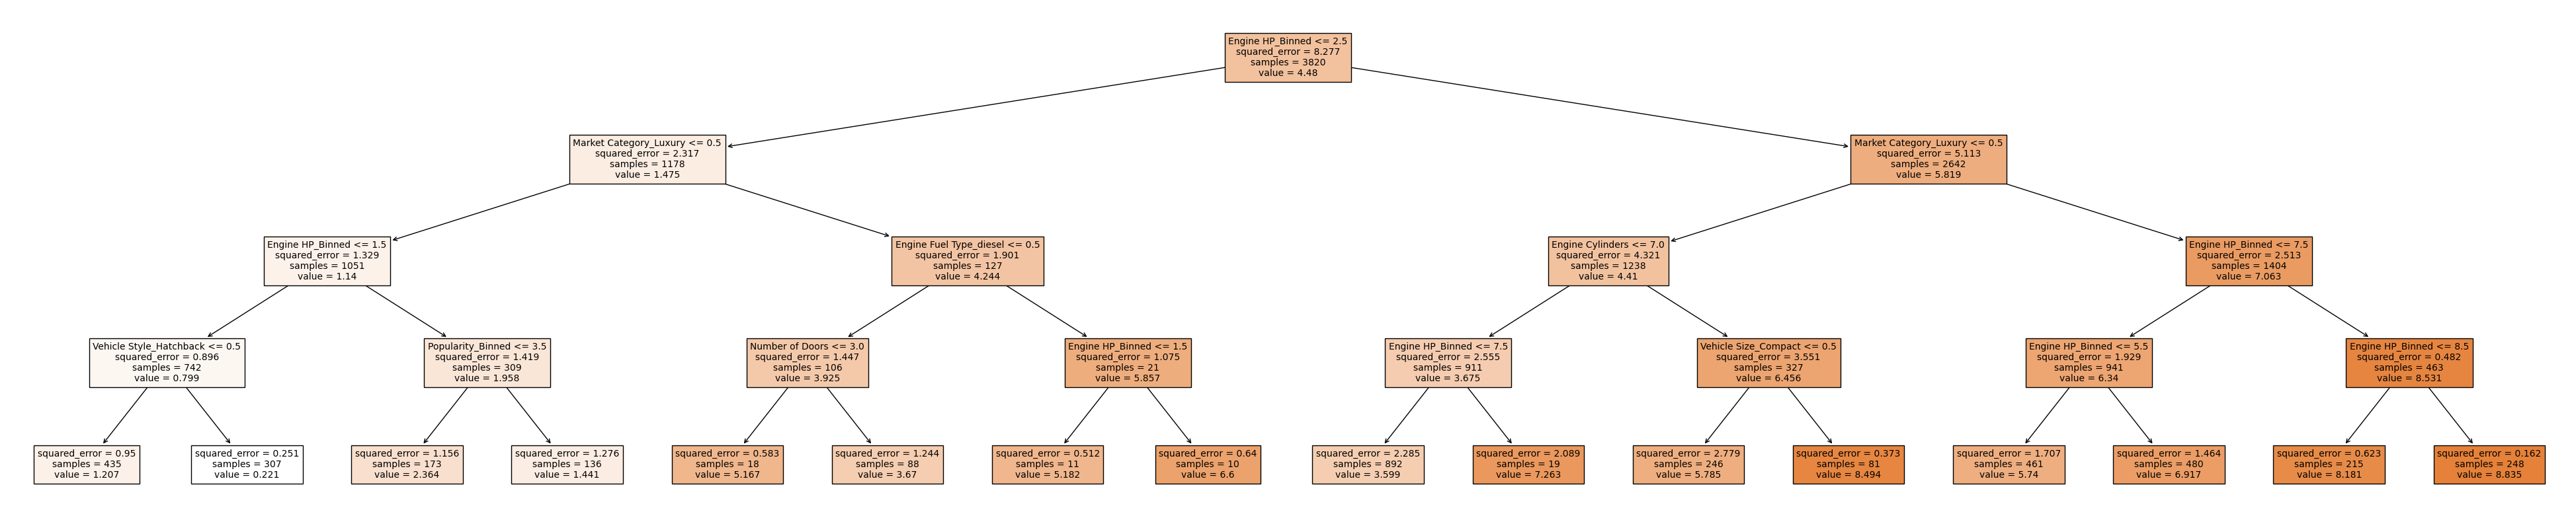

In [68]:
#decision tree depth 4

import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_ML_data8.csv')
X = df.drop('MSRP_Binned', axis=1)
y = df['MSRP_Binned']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object']))
encoded_columns = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns, index=X.index)

X_combined = pd.concat([X_encoded_df, X.select_dtypes(exclude=['object'])], axis=1)

X_combined.columns = X_combined.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(50,10))
plot_tree(tree_model, filled=True, feature_names=X_combined.columns.tolist(), max_depth=5, fontsize=10)
plt.show()


In [61]:
#regression on whole dataset continuous

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('cleaned_ML_data9.csv')

categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('MSRP', axis=1)
y = df['MSRP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

optimized_rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
optimized_dt_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)
optimized_lin_regressor = LinearRegression()

ensemble_regressor = VotingRegressor(estimators=[
    ('random_forest', optimized_rf_regressor),
    ('decision_tree', optimized_dt_regressor),
    ('linear_regression', optimized_lin_regressor)
])

ensemble_regressor.fit(X_train_scaled, y_train)

y_pred = ensemble_regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


Mean Squared Error: 102711195.77340434
R-squared: 0.9070572445269518


In [62]:
#regression on data removing cars over $100k continuous

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('cleaned_ML_data10.csv')

categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('MSRP', axis=1)
y = df['MSRP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

optimized_rf_regressor = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
optimized_dt_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)
optimized_lin_regressor = LinearRegression()

ensemble_regressor = VotingRegressor(estimators=[
    ('random_forest', optimized_rf_regressor),
    ('decision_tree', optimized_dt_regressor),
    ('linear_regression', optimized_lin_regressor)
])

ensemble_regressor.fit(X_train_scaled, y_train)

y_pred = ensemble_regressor.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


Mean Squared Error: 37437977.771191396
R-squared: 0.8673556725523135


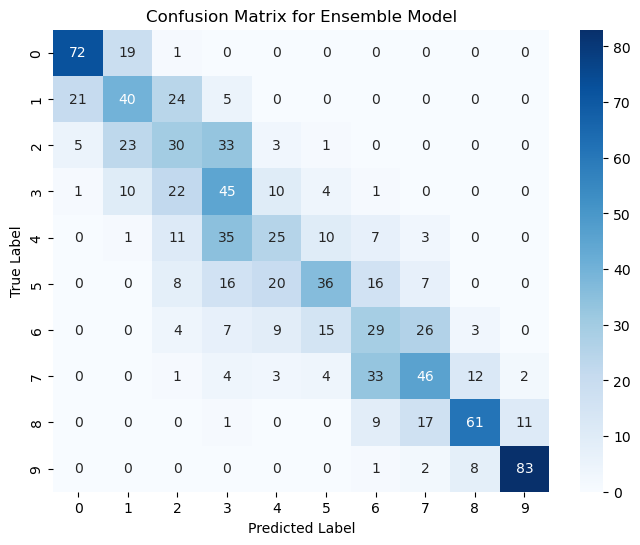

In [63]:
#classification hard voting

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('cleaned_ML_data8.csv')

categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('MSRP_Binned', axis=1)
y = df['MSRP_Binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

optimized_rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, bootstrap=False, random_state=42)
optimized_dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
optimized_log_model = LogisticRegression(C=1, max_iter=500, random_state=42)

log_pipeline = make_pipeline(StandardScaler(), optimized_log_model)

ensemble_model = VotingClassifier(estimators=[
    ('random_forest', optimized_rf_model),
    ('decision_tree', optimized_dt_model),
    ('logistic_regression', log_pipeline)
], voting='hard')

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Ensemble Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


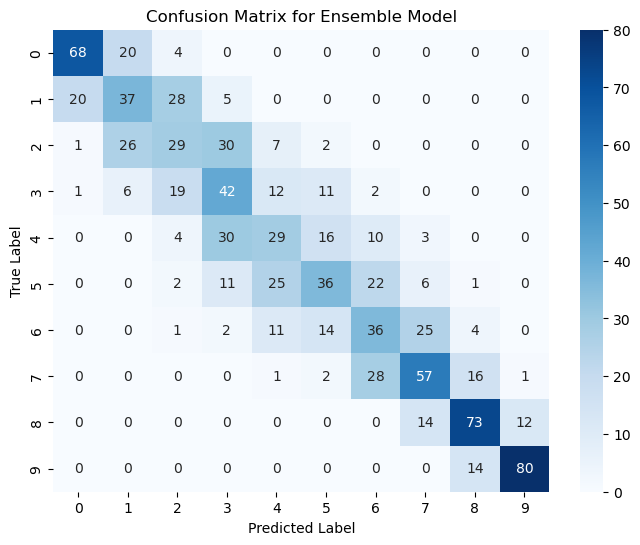

ROC AUC (macro, one-vs-rest): 0.9077818016073549
Precision: 0.5096753851603603
Recall: 0.5094142259414226
F1 Score: 0.508020360688561


In [64]:
#classification soft voting

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('cleaned_ML_data8.csv')

categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('MSRP_Binned', axis=1)
y = df['MSRP_Binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

optimized_rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, bootstrap=False, random_state=42)
optimized_dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
optimized_log_model = LogisticRegression(C=1, max_iter=500, random_state=42)

log_pipeline = make_pipeline(StandardScaler(), optimized_log_model)

ensemble_model = VotingClassifier(estimators=[
    ('random_forest', optimized_rf_model),
    ('decision_tree', optimized_dt_model),
    ('logistic_regression', log_pipeline)
], voting='soft')

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Ensemble Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42)

one_vs_rest_classifier = OneVsRestClassifier(ensemble_model)

one_vs_rest_classifier.fit(X_train_scaled, y_train_bin)

y_pred_prob = one_vs_rest_classifier.predict_proba(X_test_scaled)

roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")

y_pred = ensemble_model.predict(X_test_scaled)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'ROC AUC (macro, one-vs-rest): {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')



Accuracy for Stacking Classifier: 0.5303347280334728
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        92
           1       0.40      0.43      0.42        90
           2       0.39      0.36      0.37        95
           3       0.34      0.32      0.33        93
           4       0.34      0.38      0.36        92
           5       0.41      0.42      0.42       103
           6       0.44      0.44      0.44        93
           7       0.64      0.57      0.60       105
           8       0.70      0.76      0.73        99
           9       0.87      0.89      0.88        94

    accuracy                           0.53       956
   macro avg       0.53      0.53      0.53       956
weighted avg       0.53      0.53      0.53       956



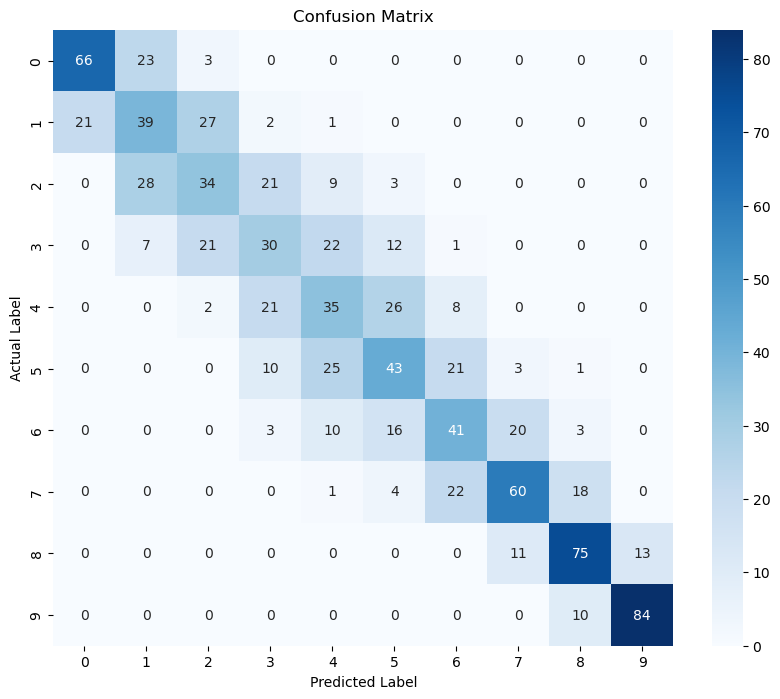

Run 9 - Accuracy for Stacking Classifier: 0.5303347280334728
Run 9 - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        92
           1       0.40      0.43      0.42        90
           2       0.39      0.36      0.37        95
           3       0.34      0.32      0.33        93
           4       0.34      0.38      0.36        92
           5       0.41      0.42      0.42       103
           6       0.44      0.44      0.44        93
           7       0.64      0.57      0.60       105
           8       0.70      0.76      0.73        99
           9       0.87      0.89      0.88        94

    accuracy                           0.53       956
   macro avg       0.53      0.53      0.53       956
weighted avg       0.53      0.53      0.53       956



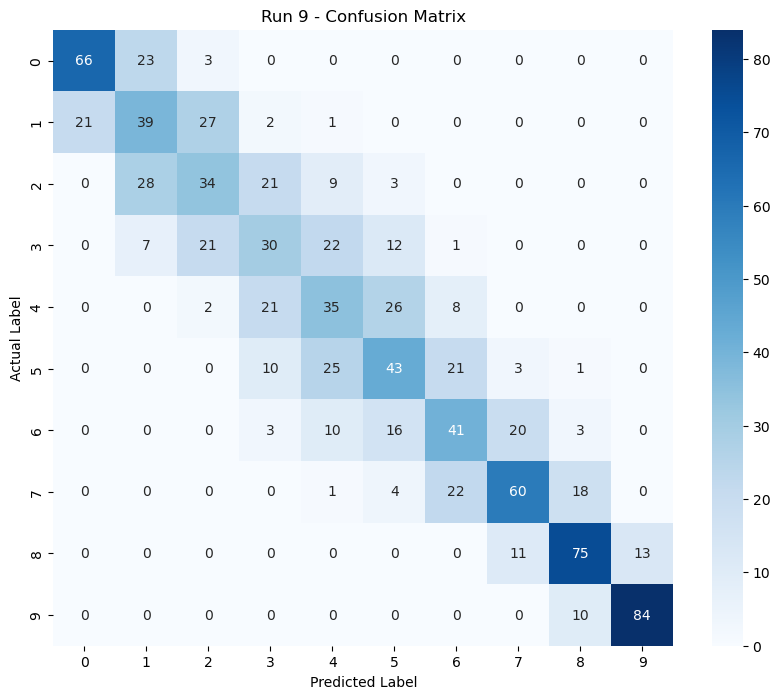

Run 9 - Precision: 0.53
Run 9 - Recall: 0.53
Run 9 - F1 Score: 0.53
Run 9 - ROC AUC: 0.92
Precision: 0.53
Recall: 0.53
F1 Score: 0.53
ROC AUC: 0.92


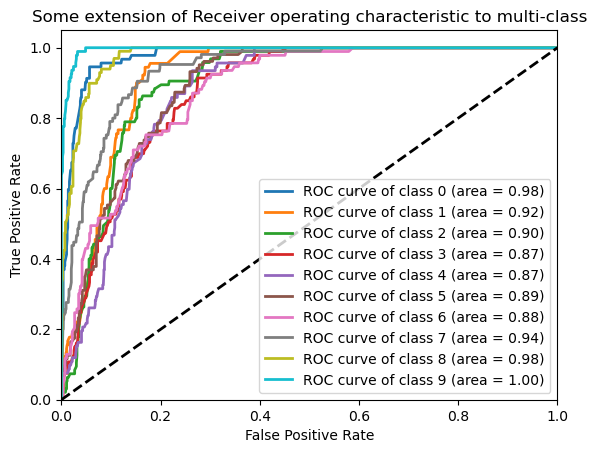

In [65]:
#classification on 10 classes by percentile MSRP

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

data = pd.read_csv('cleaned_ML_data8.csv')

categorical_features = ['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Market Category', 'Vehicle Size', 'Vehicle Style']
binned_features = ['highway MPG_Binned', 'city mpg_Binned', 'Popularity_Binned', 'Engine HP_Binned'] 
numerical_features = ['Engine Cylinders', 'Number of Doors']

combined_categorical_binned_features = categorical_features + binned_features

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, combined_categorical_binned_features)
    ],
    remainder='passthrough' 
)

X = data.drop('MSRP_Binned', axis=1)
y = data['MSRP_Binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

stacking_classifier = StackingClassifier(
    estimators=[
        ('naive_bayes', nb_pipeline),
        ('random_forest', rf_pipeline)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

stacking_classifier.fit(X_train, y_train)

y_pred = stacking_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy for Stacking Classifier: {accuracy}')

y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_proba = stacking_classifier.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')

conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=np.unique(y_train).astype(str)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


num_runs = 9

for run in range(1, num_runs + 1):
    stacking_classifier.fit(X_train, y_train)

    y_pred = stacking_classifier.predict(X_test)

    if run == 9:

        accuracy = accuracy_score(y_test, y_pred)
        print(f'Run {run} - Accuracy for Stacking Classifier: {accuracy}')

        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f'Run {run} - Classification Report:\n{classification_report(y_test, y_pred, target_names=np.unique(y_train).astype(str))}')

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Run {run} - Confusion Matrix')
        plt.show()

        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        print(f'Run {run} - Precision: {precision:.2f}')
        print(f'Run {run} - Recall: {recall:.2f}')
        print(f'Run {run} - F1 Score: {f1:.2f}')

        roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
        print(f'Run {run} - ROC AUC: {roc_auc:.2f}')

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

fpr = dict()
tpr = dict()
roc_auc_class = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc_class[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_class[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


Accuracy for Stacking Classifier: 0.99581589958159
              precision    recall  f1-score   support

      budget       1.00      1.00      1.00       240
     economy       1.00      1.00      1.00       456
      luxury       0.97      0.99      0.98        72
 performance       1.00      0.99      1.00       169
    supercar       0.94      0.89      0.92        19

    accuracy                           1.00       956
   macro avg       0.98      0.97      0.98       956
weighted avg       1.00      1.00      1.00       956



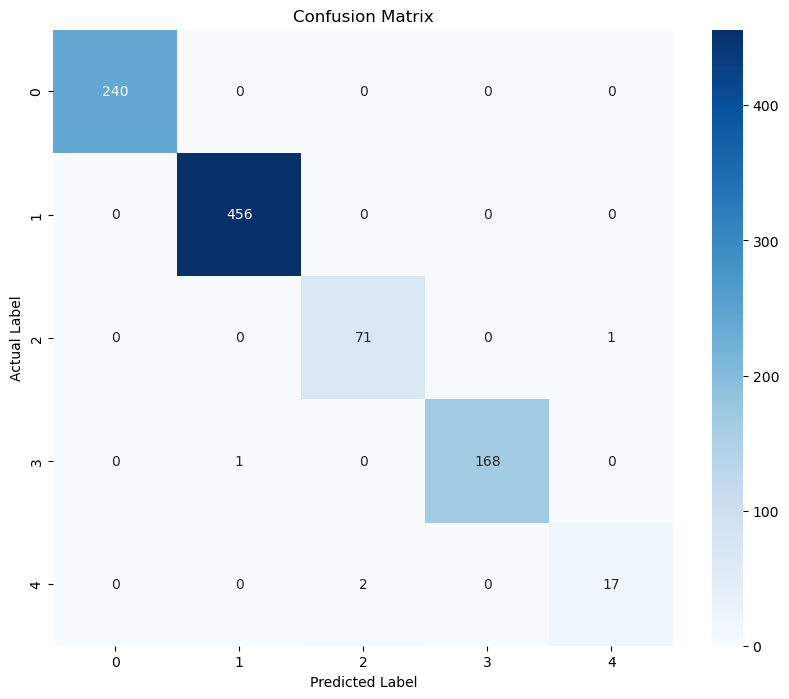

Run 9 - Accuracy for Stacking Classifier: 0.99581589958159
Run 9 - Classification Report:
              precision    recall  f1-score   support

      budget       1.00      1.00      1.00       240
     economy       1.00      1.00      1.00       456
      luxury       0.97      0.99      0.98        72
 performance       1.00      0.99      1.00       169
    supercar       0.94      0.89      0.92        19

    accuracy                           1.00       956
   macro avg       0.98      0.97      0.98       956
weighted avg       1.00      1.00      1.00       956



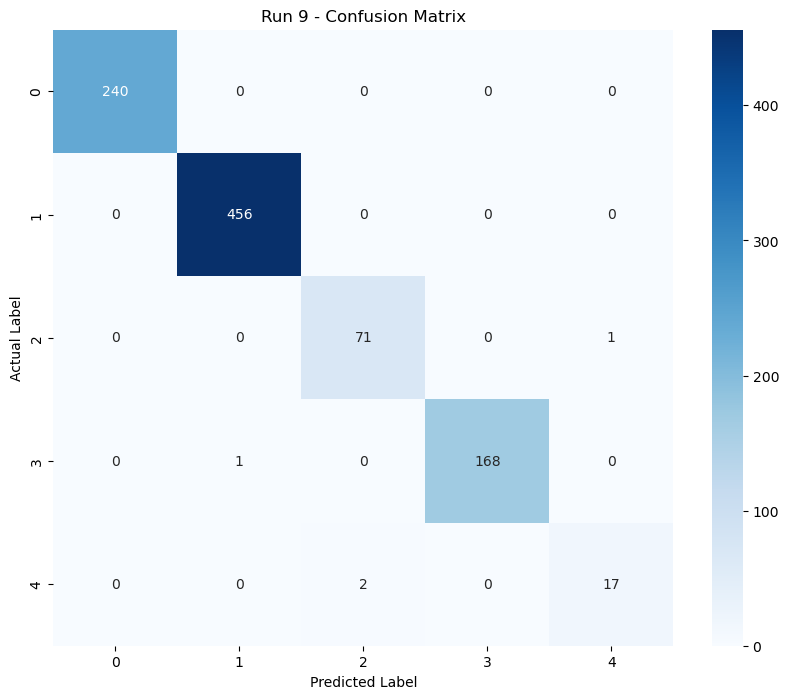

Run 9 - Precision: 1.00
Run 9 - Recall: 1.00
Run 9 - F1 Score: 1.00
Run 9 - ROC AUC: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
ROC AUC: 1.00


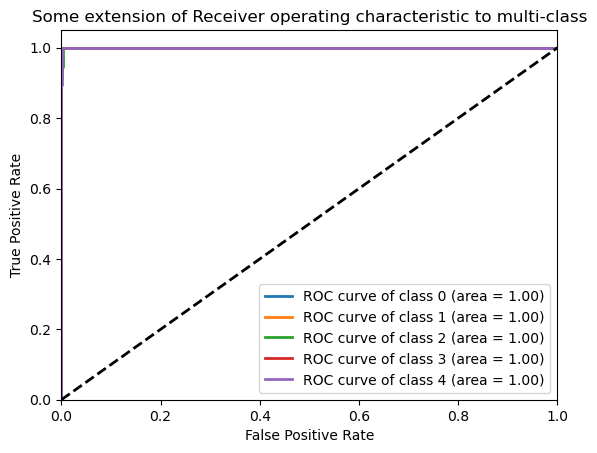

In [66]:
#classification on types of cars in strings
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

data = pd.read_csv('cleaned_ML_data12.csv')

categorical_features = ['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Market Category', 'Vehicle Size', 'Vehicle Style']
binned_features = ['highway MPG_Binned', 'city mpg_Binned', 'Popularity_Binned', 'Engine HP_Binned'] 
numerical_features = ['Engine Cylinders', 'Number of Doors']

combined_categorical_binned_features = categorical_features + binned_features

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, combined_categorical_binned_features)
    ],
    remainder='passthrough'  
)

X = data.drop('Category', axis=1)
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

stacking_classifier = StackingClassifier(
    estimators=[
        ('naive_bayes', nb_pipeline),
        ('random_forest', rf_pipeline)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

stacking_classifier.fit(X_train, y_train)

y_pred = stacking_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy for Stacking Classifier: {accuracy}')

y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_proba = stacking_classifier.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')

conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=np.unique(y_train).astype(str)))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


num_runs = 9

for run in range(1, num_runs + 1):
    stacking_classifier.fit(X_train, y_train)

    y_pred = stacking_classifier.predict(X_test)

    if run == 9:
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Run {run} - Accuracy for Stacking Classifier: {accuracy}')

        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f'Run {run} - Classification Report:\n{classification_report(y_test, y_pred, target_names=np.unique(y_train).astype(str))}')

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Run {run} - Confusion Matrix')
        plt.show()
        
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        print(f'Run {run} - Precision: {precision:.2f}')
        print(f'Run {run} - Recall: {recall:.2f}')
        print(f'Run {run} - F1 Score: {f1:.2f}')

        roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
        print(f'Run {run} - ROC AUC: {roc_auc:.2f}')

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

fpr = dict()
tpr = dict()
roc_auc_class = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc_class[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_class[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
